In [127]:
import csv
import numpy as np
import pandas as pd
import numpy as np
import os
import re 
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import Polynomial
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


In [128]:
file = open('flexural/ES100_Trevor_Flexural_Data_1_1.csv')
type(file)

_io.TextIOWrapper

In [129]:
csvreader = csv.reader(file)
header = []
header = next(csvreader)
header

['Specimen text inputs : Specimen text input  1', '', '']

In [130]:
id_dict = {'Basalt 0deg': [1, 2], 'Hemp 45deg': [11, 12], 'Flax 45deg': [7,8], 'Basalt Hemp 0deg': [13, 14], 'Hemp 0deg': [9, 10], 'Flax 0deg': [5,6], 'Basalt Flax 0deg': [15, 16], 'Basalt 45deg': [3,4]}

In [131]:
import pandas as pd
import numpy as np
import os
import re  # Import regular expressions for finding the id in the file name

def get_name_for_id(id_num):
    for name, ids in id_dict.items():
        if id_num in ids:
            return name
    return None 

def convert_to_numeric(df, column_names):
    for column in column_names:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

def average_n_values(df, n):
    avg_df = df.groupby(np.arange(len(df)) // n).mean()
    avg_df['Time'] = avg_df['Time'].round().astype(int)
    return avg_df

folder_path = 'flexural'
n = 50 
dfs = []

names = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        # Attempt to automatically detect the start of the data
        with open(file_path, 'r') as file:
            for i, line in enumerate(file):
                if line.strip().split(',')[0] == "Time":
                    header_line = i
                    break

        # Extract the id number from the file name using regular expressions
        match = re.search(r"ES100_Trevor_Flexural_Data_(\d+)_1.csv", file_name)
        if match:
            id_num = int(match.group(1))
            name = get_name_for_id(id_num)
            if name:
                file_name_modified = file_name.replace(f"ES100_Trevor_Flexural_Data_{id_num}_1", f"{name}_{names.count(name) + 1}")
                names.append(name)
            else:
                file_name_modified = file_name
        else:
            file_name_modified = file_name

        df = pd.read_csv(file_path, skiprows=header_line)

        df = convert_to_numeric(df, ['Time', 'Displacement', 'Force'])

        df_avg = average_n_values(df, n)
        print(file_name_modified)
        df_avg['File_ID'] = os.path.splitext(file_name_modified)[0]

        df_avg['Material_ID'] = file_name.replace(f"ES100_Trevor_Flexural_Data_{id_num}_1.csv", f"{name}")

        dfs.append(df_avg)

filtered_combined_df = pd.concat(dfs, ignore_index=True)

# Concatenate all filtered DataFrames
# filtered_combined_df = pd.concat(combined_df, ignore_index=True)

filtered_combined_df['Displacement'] -= filtered_combined_df.groupby('File_ID')['Displacement'].transform('first')

# Save the filtered combined dataframe
filtered_combined_df.to_csv('combined_flexural.csv', index=False)



print("Processing complete. The combined CSV is saved as 'combined_flexural.csv'.")


Hemp 0deg_1.csv
Hemp 45deg_1.csv
Hemp 45deg_2.csv
Basalt Hemp 0deg_1.csv
Basalt Hemp 0deg_2.csv
Basalt Flax 0deg_1.csv
Basalt Flax 0deg_2.csv
Basalt 0deg_1.csv
Basalt 0deg_2.csv
Basalt 45deg_1.csv
Basalt 45deg_2.csv
Flax 0deg_1.csv
Flax 0deg_2.csv
Flax 45deg_1.csv
Flax 45deg_2.csv
Hemp 0deg_2.csv
Processing complete. The combined CSV is saved as 'combined_flexural.csv'.


In [132]:
import matplotlib.pyplot as plt
import pandas as pd

combined_df = pd.read_csv('combined_flexural.csv')
file_ids = combined_df['File_ID'].unique()

for file_id in file_ids:
    df_filtered = combined_df[combined_df['File_ID'] == file_id]


In [133]:
# Load the combined data
combined_df = pd.read_csv('combined_flexural.csv')

def truncate_at_downtrend(df, value_columns):
    """Truncates the DataFrame at the start of a downtrend for specified columns."""
    for column in value_columns:
        # Find the first instance where the next value is less than the current value
        downtrend_start = np.where(df[column].diff() < 0)[0]
        if downtrend_start.size > 0:
            # If a downtrend is found, truncate the DataFrame up to that point
            return df.iloc[:downtrend_start[0]]
    return df

truncated_dfs = []

# Process each unique File_ID
for file_id in combined_df['File_ID'].unique():
    df_filtered = combined_df[combined_df['File_ID'] == file_id]
    
    # Truncate the DataFrame at the start of a downtrend for 'Displacement' and 'Force'
    df_truncated = truncate_at_downtrend(df_filtered, ['Displacement', 'Force'])
    truncated_dfs.append(df_truncated)

# Combine truncated DataFrames
truncated_combined_df = pd.concat(truncated_dfs, ignore_index=True)

# Save the truncated combined DataFrame to a new CSV file
truncated_combined_df.to_csv('truncated_combined_flexural.csv', index=False)

print("Truncated data saved to 'truncated_combined_flexural.csv'.")


Truncated data saved to 'truncated_combined_flexural.csv'.


In [134]:
combined_df = pd.read_csv('truncated_combined_flexural.csv')

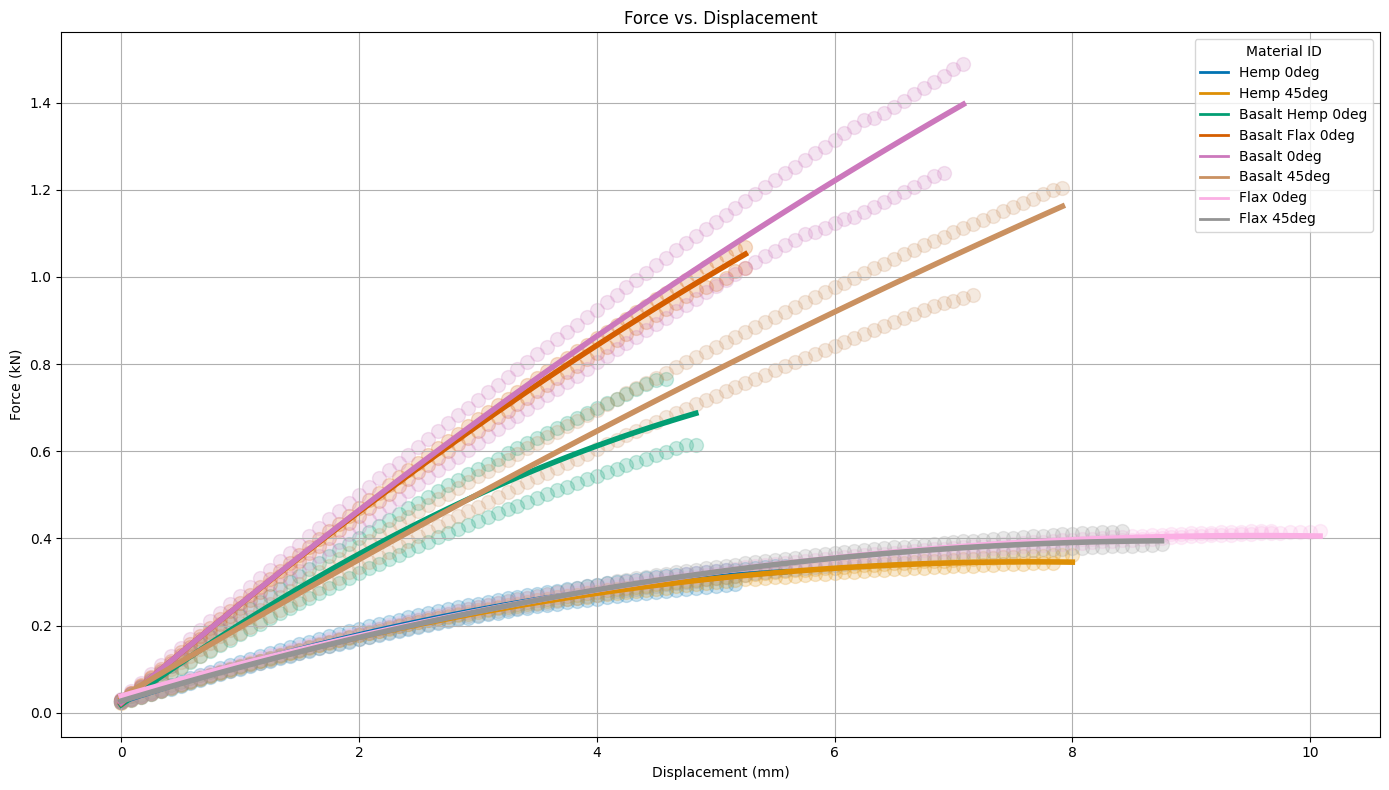

In [150]:
plt.figure(figsize=(14, 8))
from matplotlib.lines import Line2D

# Create a color palette with a distinct color for each Material_ID
palette = sns.color_palette("colorblind", len(combined_df['Material_ID'].unique()))

# Initialize an empty list for custom legend handles
custom_legend_handles = []

# Plot all data points with colors corresponding to Material ID
for material_id in combined_df['Material_ID'].unique():
    material_data = combined_df[combined_df['Material_ID'] == material_id]
    plt.scatter(material_data['Displacement'], material_data['Force'], color=palette[list(combined_df['Material_ID'].unique()).index(material_id)], alpha=0.2, s=100)

    # Fit a polynomial (second degree) to the data points for this material ID
    p = np.polynomial.Polynomial.fit(material_data['Displacement'], material_data['Force'], 2)
    # Generate x values from the min to max displacement for the material
    x = np.linspace(material_data['Displacement'].min(), material_data['Displacement'].max(), 100)
    # Calculate the y values using the polynomial
    y = p(x)
    # Plot the fitting curve
    line = plt.plot(x, y, linewidth=4, color=palette[list(combined_df['Material_ID'].unique()).index(material_id)])
    
    # Add a custom legend handle for this line
    custom_legend_handles.append(Line2D([0], [0], color=line[0].get_color(), linewidth=2))

# Create a custom legend using the handles and labels from the regression lines
plt.legend(custom_legend_handles, combined_df['Material_ID'].unique(), title="Material ID", fontsize='medium')

plt.title('Force vs. Displacement')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (kN)')
plt.grid(True)
plt.tight_layout()
plt.show()

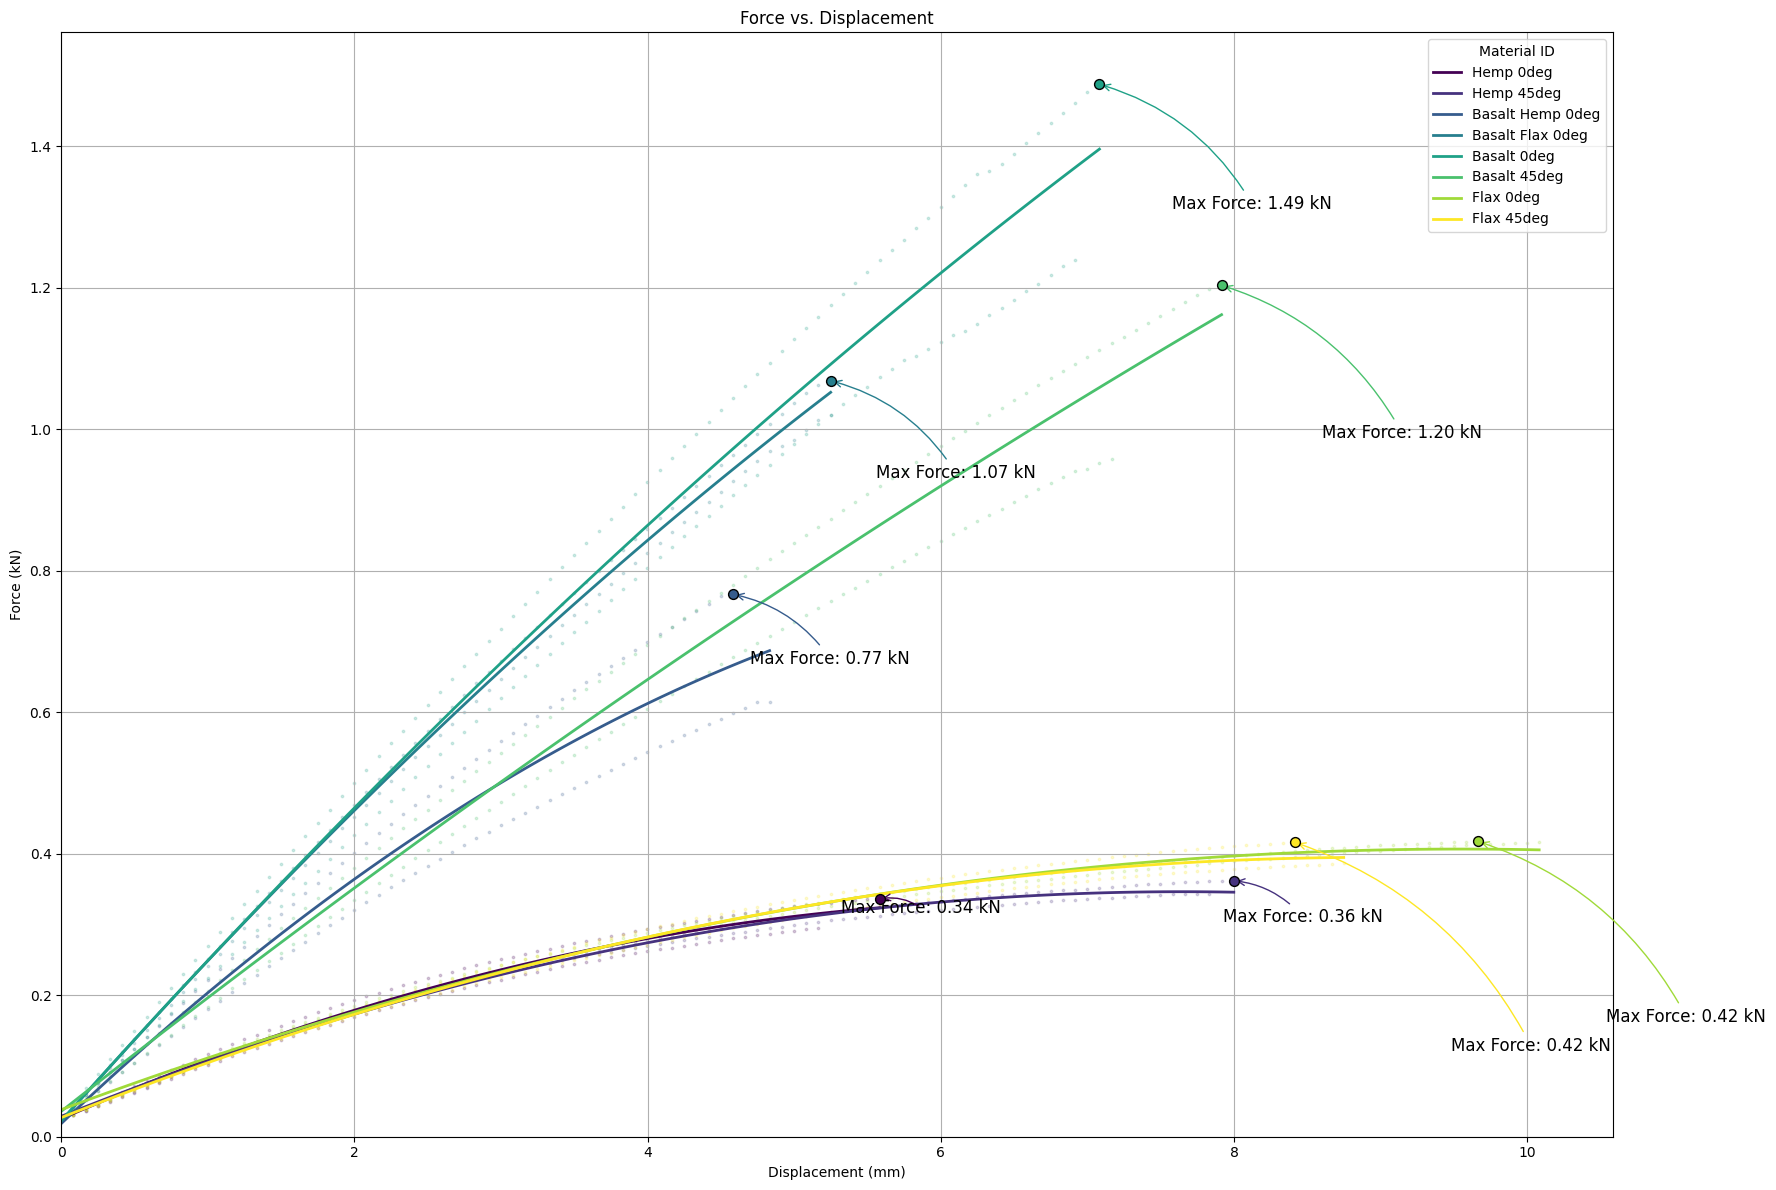

In [138]:
from numpy.polynomial.polynomial import Polynomial
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming combined_df and color_map are already defined

plt.figure(figsize=(18, 12))

annotation_positions = []

for material_id in unique_materials:
    # Filter rows for the current material ID
    material_data = combined_df[combined_df['Material_ID'] == material_id]
    plt.scatter(material_data['Displacement'], material_data['Force'], color=color_map[material_id], alpha=0.2, s=3)

    # Prepare data for polynomial fit with RANSAC
    X = material_data['Displacement'].values.reshape(-1, 1)
    y = material_data['Force'].values

    # Create a RANSAC regressor with a polynomial model
    ransac = make_pipeline(PolynomialFeatures(degree=2), RANSACRegressor(random_state=42))
    ransac.fit(X, y)

    # Generate x values from the min to max displacement for the material
    x = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    # Calculate the y values using the RANSAC polynomial model
    y_ransac = ransac.predict(x)
    # Plot the fitting curve
    plt.plot(x, y_ransac, color=color_map[material_id], linewidth=2, label=f'{material_id}')

    # Correct placement: Calculate and plot the max force point within the loop
    max_force = material_data['Force'].max()
    max_force_disp = material_data.loc[material_data['Force'].idxmax(), 'Displacement']
    plt.scatter(max_force_disp, max_force, color=color_map[material_id], edgecolor='black', 
                s=50, zorder=5)


    # CHANGE THESE OFFSETS AND THE "< 20" bound in while condition
    
    # Determine a suitable position for the annotation
    xytext = (30, -10)  # Default annotation offset

    # Check for overlap and adjust position if necessary
    while any(np.linalg.norm(np.array((xytext[0], xytext[1])) - np.array(pos)) < 20 for pos in annotation_positions):
        xytext = (xytext[0] + 10, xytext[1] - 10)  # Adjust position to reduce overlap

    annotation_positions.append(xytext)  # Store the position

    # Annotate with a connection line
    plt.annotate(f'Max Force: {max_force:.2f} kN', 
                 (max_force_disp, max_force),
                 textcoords="offset points", 
                 xytext=xytext, 
                 ha='center', 
                 fontsize=12,
                 arrowprops=dict(arrowstyle="->", color=color_map[material_id], connectionstyle="arc3,rad=0.2"))

# Add legend, titles, and labels
plt.xlim(0, None)
plt.ylim(0, None)
plt.legend(title="Material ID")
plt.title('Force vs. Displacement')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (kN)')
plt.grid(True)
plt.tight_layout()
# plt.savefig('figs/polynomial_fit_ransac_per_material_corrected.png')
plt.show()


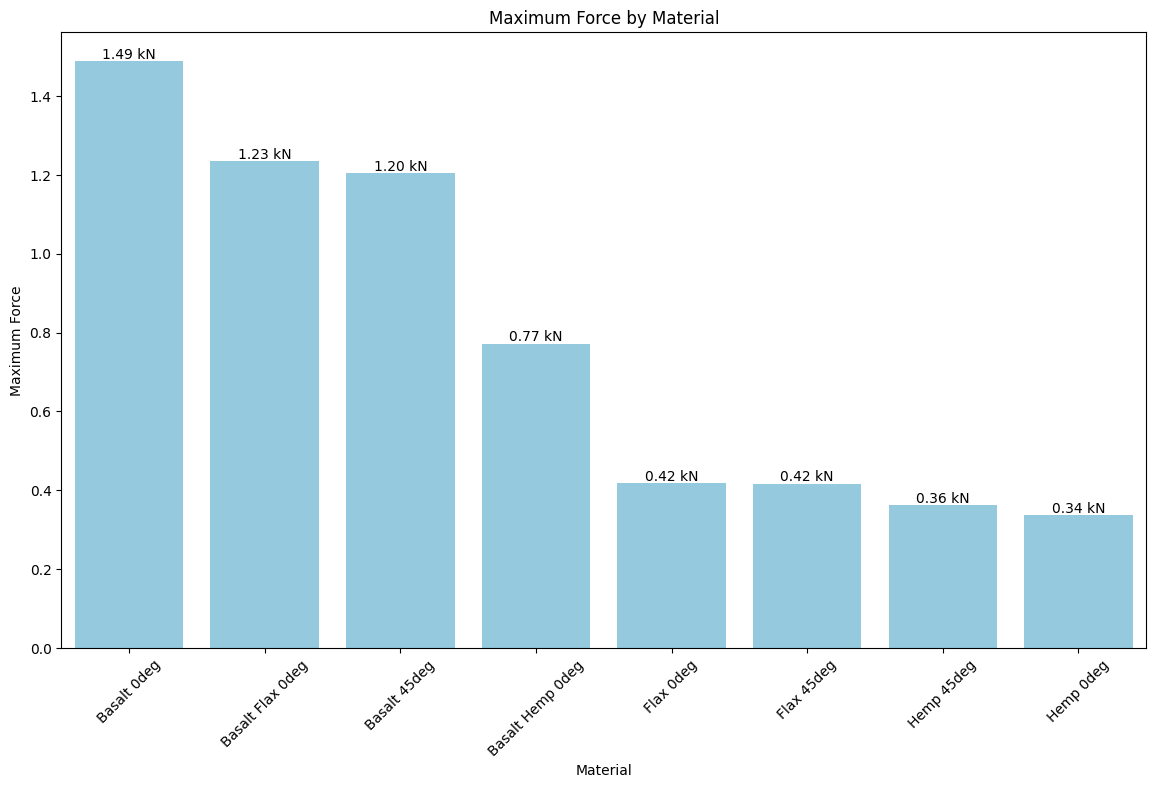

In [139]:
# Plot the max force on a  bar plot
plt.figure(figsize=(14, 8))

df = pd.read_csv('combined_flexural.csv')

max_force_per_material = df.groupby('Material_ID')['Force'].max().reset_index()

max_force_per_material = max_force_per_material.sort_values(by='Force', ascending=False)


bars = sns.barplot(y='Force', x='Material_ID', data=max_force_per_material, color='skyblue')
plt.title('Maximum Force by Material')
plt.ylabel('Maximum Force')
plt.xlabel('Material')

for bar in bars.patches:
    height = bar.get_height()
    annotation = "{:.2f} kN".format(height)
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, annotation, ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()


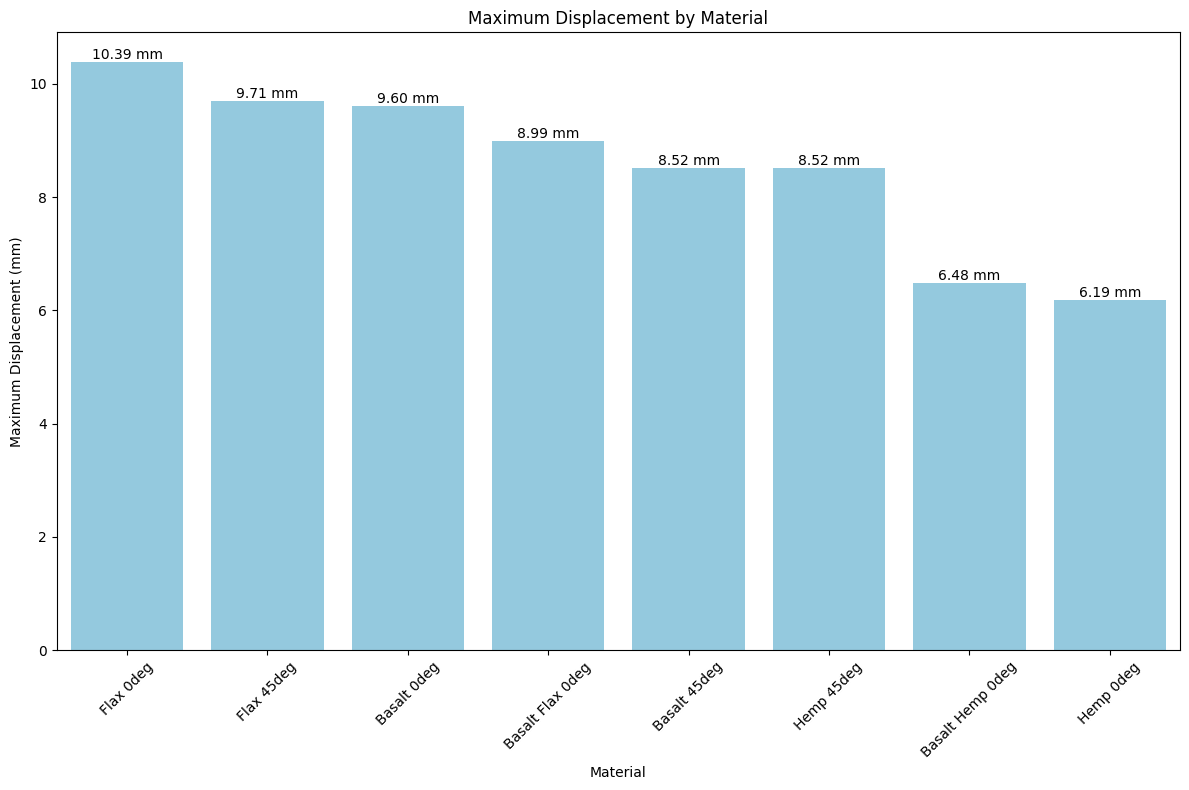

In [140]:
max_displacement_per_file = df.groupby(['Material_ID', 'File_ID'])['Displacement'].max().reset_index()

average_max_displacement_per_material = max_displacement_per_file.groupby('Material_ID')['Displacement'].mean().reset_index()

average_max_displacement_per_material = average_max_displacement_per_material.sort_values(by='Displacement', ascending=False)

plt.figure(figsize=(12, 8))
bars = sns.barplot(y='Displacement', x='Material_ID', data=average_max_displacement_per_material, color='skyblue')
plt.title('Maximum Displacement by Material')
plt.ylabel('Maximum Displacement (mm)')
plt.xlabel('Material')

for bar in bars.patches:
    height = bar.get_height()
    annotation = "{:.2f} mm".format(height)
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, annotation, ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

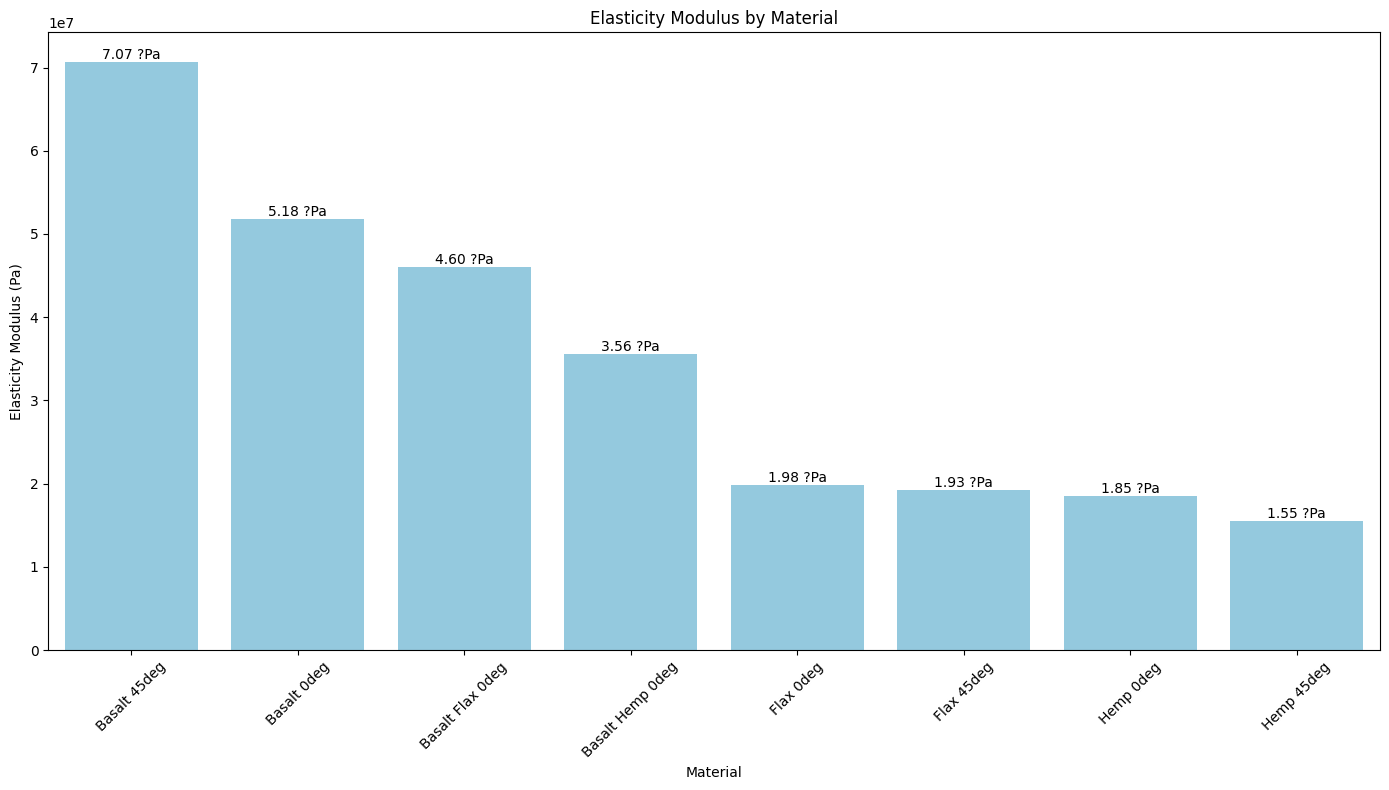

In [141]:
import matplotlib.pyplot as plt

# Example b and d values for each material
material_properties = {
    'Basalt 0deg': {'b': 0.01426, 'd': 0.006},
    'Hemp 45deg': {'b': 0.01426, 'd': 0.00615},
    'Flax 45deg': {'b': 0.01426, 'd': 0.00571},
    'Basalt Hemp 0deg': {'b': 0.01426, 'd': 0.00612},
    'Hemp 0deg': {'b': 0.01426, 'd': 0.00625},
    'Flax 0deg': {'b': 0.01426, 'd': 0.00555},
    'Basalt Flax 0deg': {'b': 0.01426, 'd': 0.00632},
    'Basalt 45deg': {'b': 0.01426, 'd': 0.00552},

    # Define other materials here
}

# Assuming 'df' is your DataFrame and it includes a 'Material_ID' column
# and a 'Strain' column for the x-axis
# Store average elasticity modulus for each material
average_elasticity_modulus = []

# Loop through each unique material in the DataFrame
for material_id in df['Material_ID'].unique():
    # Filter the DataFrame for the current material
    material_df = df[df['Material_ID'] == material_id]

    # Retrieve b and d values for the current material
    b = material_properties[material_id]['b']
    d = material_properties[material_id]['d']

    # Calculate numerator and denominator using the specific b and d
    nume = material_df['Force'].max() * (0.17**3) * 1000
    deno = material_df['Displacement'].max() * 4 * b * (d**3)

    # Calculate elasticity modulus for the current material
    elasticity_modulus = nume / deno
    # Calculate the average elasticity modulus for the material
    avg_modulus = elasticity_modulus.mean()
    average_elasticity_modulus.append(avg_modulus)

# Assuming the number of unique materials matches the length of average_elasticity_modulus
materials = list(df['Material_ID'].unique())

materials_modulus = list(zip(materials, average_elasticity_modulus))

# Sort the list of tuples by the average elasticity modulus (the second element of each tuple)
sorted_materials_modulus = sorted(materials_modulus, key=lambda x: x[1], reverse=True)

# Unzip the sorted list of tuples back into two lists
sorted_materials, sorted_average_elasticity_modulus = zip(*sorted_materials_modulus)

# Create a DataFrame from the sorted materials modulus information
modulus_df = pd.DataFrame(sorted_materials_modulus, columns=['Material', 'Average_Elasticity_Modulus'])

# Plot using seaborn
plt.figure(figsize=(14, 8))
modulus_plot = sns.barplot(x='Material', y='Average_Elasticity_Modulus', data=modulus_df, color='skyblue')

plt.title("Elasticity Modulus by Material")
plt.xlabel('Material')
plt.ylabel('Elasticity Modulus (Pa)')

# Add labels on top of each bar
for bar in modulus_plot.patches:
    height = bar.get_height()
    annotations = "{:.2f} ?Pa".format(height/10000000)
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, annotations, ha='center', va='bottom')

plt.xticks(rotation=45)  # Rotate the material names for better readability
plt.tight_layout()
plt.show()


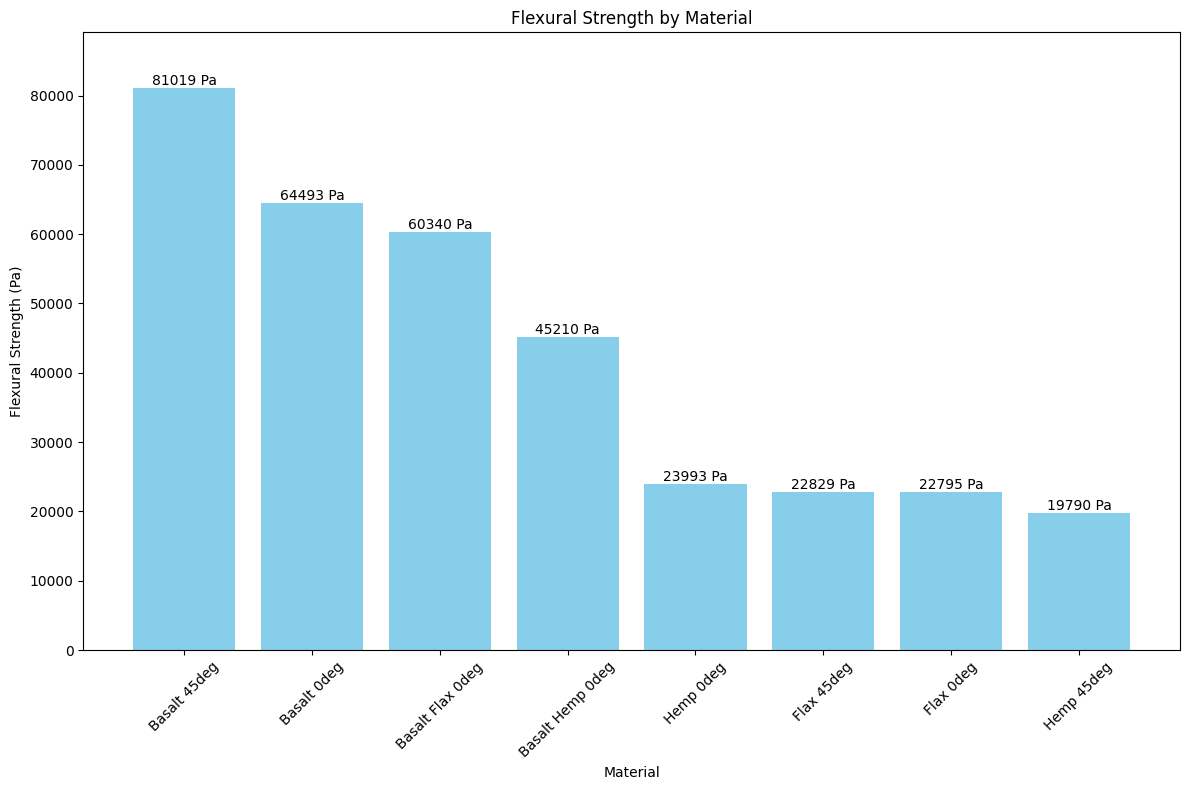

In [142]:
average_flexural_strength = []

# Loop through each unique material in the DataFrame
for material_id in df['Material_ID'].unique():
    # Filter the DataFrame for the current material
    material_df = df[df['Material_ID'] == material_id]

    # Retrieve b and d values for the current material
    b = material_properties[material_id]['b']
    d = material_properties[material_id]['d']

    # Calculate numerator and denominator using the specific b and d
    nume = material_df['Force'].max() * 3 * 0.17
    deno = material_df['Displacement'].max() * 2 * b * (d**2)

    # Calculate elasticity modulus for the current material
    flexural_strength = nume / deno
    # Calculate the average elasticity modulus for the material
    avg_fs = flexural_strength.mean()
    average_flexural_strength.append(avg_fs)

# Assuming the number of unique materials matches the length of average_elasticity_modulus
materials = list(df['Material_ID'].unique())

materials_fs = list(zip(materials, average_flexural_strength))

# Sort the list of tuples by the average elasticity modulus (the second element of each tuple)
sorted_materials_fs = sorted(materials_fs, key=lambda x: x[1], reverse=True)

# Unzip the sorted list of tuples back into two lists
sorted_materials, sorted_average_fs = zip(*sorted_materials_fs)

# Creating the sorted bar plot
plt.figure(figsize=(12, 8))
max_value = max(sorted_average_fs)
upper_limit = max_value * 1.1  # Set upper limit to 10% higher than the maximum value

# Adjust the ylim to make room for annotations
plt.ylim(0, upper_limit)
bars = plt.bar(sorted_materials, sorted_average_fs, color='skyblue')
plt.xlabel('Material')
plt.ylabel('Flexural Strength (Pa)')
plt.title('Flexural Strength by Material')

for bar in bars:
    height = bar.get_height()
    annotation = "{:.0f} Pa".format(height)
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, annotation, ha='center', va='bottom')


plt.xticks(rotation=45)  # Rotate the material names for better readability
plt.tight_layout()
plt.show()
